<a href="https://colab.research.google.com/github/spursbyte/algorithms_from_scratch/blob/main/cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
from sklearn import tree
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
%matplotlib inline

In [9]:
df = pd.read_csv('winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [10]:
df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [11]:
# mapping dictionary that maps the quality values from 0 to 5
quality_mapping = {
    3: 0,
    4: 1,
    5: 2,
    6: 3,
    7: 4,
    8: 5
}

# lets change the quality column with our new values based on the mapping dictionary
df.loc[:, 'quality'] = df.quality.map(quality_mapping)

In [12]:
df['quality'].value_counts()

2    681
3    638
4    199
1     53
5     18
0     10
Name: quality, dtype: int64

## Splitting the data

In [13]:
df.shape

(1599, 12)

In [14]:
# shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

# lets select the top 1000 for training
df_train = df.head(1000)

# and the bottom 599 for testing
df_test = df.tail(599)

## Train a Decision Tree

In [15]:
clf = tree.DecisionTreeClassifier(max_depth=7)

# features of the model
cols = ['fixed acidity',
        'volatile acidity',
        'citric acid',
        'residual sugar',
        'chlorides',
        'free sulfur dioxide',
        'total sulfur dioxide',
        'density',
        'pH',
        'sulphates',
        'alcohol']

# train the model
clf.fit(df_train[cols], df_train.quality)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## Generate Predictions

In [16]:
# predict over the train set
train_predictions = clf.predict(df_train[cols])

# predict over the test set
test_predictions = clf.predict(df_test[cols])

# calculate accuracy on the train set
train_accuracy = metrics.accuracy_score(df_train.quality, train_predictions)

# calculate accuracy on the test set
test_accuracy = metrics.accuracy_score(df_test.quality, test_predictions)


print(f'train_accuracy: {train_accuracy}')
print(f'test_accuracy: {test_accuracy}')

train_accuracy: 0.754
test_accuracy: 0.5242070116861436


## Training with different max_depths

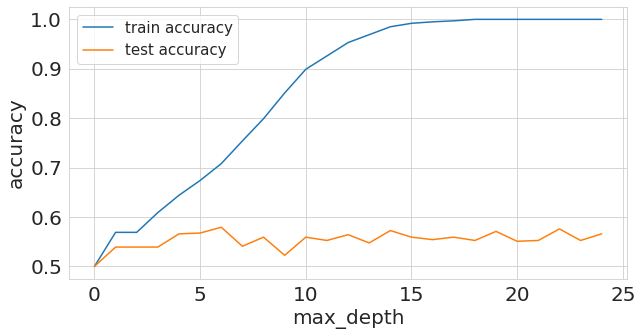

In [17]:
train_accuracies = [0.5]
test_accuracies = [0.5]

# iterata over a few depth values
for depth in range(1, 25):
    # init model
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    
    # fit the model
    clf.fit(df_train[cols], df_train.quality)
    
    # training and test predictions
    train_predictions = clf.predict(df_train[cols])
    test_predictions = clf.predict(df_test[cols])

    # training and test acurracies
    train_accuracy = metrics.accuracy_score(df_train.quality, train_predictions)
    test_accuracy = metrics.accuracy_score(df_test.quality, test_predictions)
    
    # append accuracies
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# create the plots
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
plt.plot(train_accuracies, label="train accuracy")
plt.plot(test_accuracies, label="test accuracy")
plt.legend(loc="upper left", prop={'size': 15})
plt.xticks(range(0, 26, 5))
plt.xlabel("max_depth", size=20)
plt.ylabel("accuracy", size=20)
plt.show()

Text(0, 0.5, 'count')

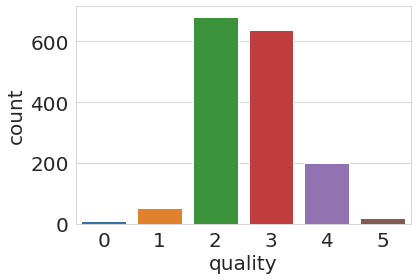

In [18]:
b = sns.countplot(x='quality', data=df)
b.set_xlabel("quality", fontsize=20)
b.set_ylabel("count", fontsize=20)

## Stratified k-fold for a regression dataset

In [19]:
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn import model_selection

In [20]:
def create_folds(data):
    # create a column called kfold and filled it whit -1
    data["kfold"] = -1
    
    # next we are gonna shuffle the rows
    data = data.sample(frac=1).reset_index(drop=True)
    
    # calculate the number of bins by Sturge's rule
    num_bins = np.floor(1 + np.log2(len(data))).astype(int)

    # bin targets
    data.loc[:, "bins"] = pd.cut(data['target'], bins=num_bins, labels=False)
    
    # init stratified kfold
    kf = model_selection.StratifiedKFold(n_splits=5)
    
    # fill the new kfold column
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, 'kfold'] = f
    
    data = data.drop("bins", axis=1)
    return data


if __name__ == "__main__":
    # we create a sample dataset with 15000 samples and 100 features and 1 target
    X, y = datasets.make_regression(n_samples=15000, n_features=100, n_targets=1)
    
    # convert to a dataframe
    df = pd.DataFrame(X, columns=[f"f_{i}" for i in range(X.shape[1])])
    df.loc[:, "target"] = y
    
    # create folds
    df = create_folds(df)

In [22]:
df.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,...,f_62,f_63,f_64,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79,f_80,f_81,f_82,f_83,f_84,f_85,f_86,f_87,f_88,f_89,f_90,f_91,f_92,f_93,f_94,f_95,f_96,f_97,f_98,f_99,target,kfold
0,-1.417085,0.666266,-0.666399,-1.209214,1.222314,0.979334,-1.165562,0.716431,-0.575718,-1.097014,0.037881,0.045984,-1.657645,-1.679993,1.637712,1.066606,-0.324877,1.472586,-0.508859,1.207708,-1.248806,-2.087267,0.232099,0.569545,0.194310,0.722436,-0.293249,0.730847,-0.965759,0.391982,0.803230,-1.918164,0.306893,-0.421539,1.280251,0.250784,0.578511,-1.017760,-1.006094,0.488385,...,-0.290847,-0.241755,-2.777390,1.876176,-0.476311,0.094601,-0.252947,1.318407,0.119234,-0.038888,0.311380,-1.185302,0.871143,-0.041992,0.701690,-1.136619,0.181919,-1.159578,-1.063300,-0.154446,0.761815,0.118449,-1.380726,-1.084661,0.614264,-2.155327,0.770018,-1.131004,-0.127905,0.162228,-2.212278,-0.999032,0.920551,-0.396220,0.672408,1.112927,-0.018737,-0.717846,-87.192128,0
1,-0.013326,-0.003051,-1.370892,-1.860962,0.161168,-0.917242,-1.250209,-0.373372,-1.923460,0.052496,1.080588,-0.174946,-1.494564,0.882962,-0.580477,1.545358,1.924489,1.180958,0.815329,-1.135344,0.518409,-0.927101,-0.111048,0.476264,1.134421,1.077371,-0.013031,0.159228,-0.410873,-0.656736,0.913817,0.086307,1.695665,-0.440976,-0.544712,0.526369,-0.140509,0.535152,0.335436,0.663221,...,-0.554000,-0.985693,-0.613684,2.227133,-0.180820,0.333533,0.572060,-0.632631,-0.264012,1.372886,0.012387,0.325026,-1.645834,-0.616530,1.087436,0.529451,-1.534495,0.320144,-0.506291,-0.771483,-1.116643,-0.289099,-0.461804,-1.225148,-0.610392,-0.691935,0.497447,-0.190312,0.249915,-0.075305,-0.628787,0.072949,-0.756414,-1.160808,-0.119717,-0.005463,0.228192,0.625895,61.468354,0
2,0.242002,0.273441,-0.552751,-0.364034,-1.635173,-0.611531,-1.823560,-0.009436,-0.585917,-0.842261,-1.029503,-0.082451,-0.716060,-0.883403,-0.616498,-0.256352,1.156155,-0.145536,-0.561151,-0.346610,-1.006811,-0.315422,0.577846,-0.103263,2.044205,0.414060,-0.786663,2.107935,-0.874925,0.669997,0.580388,-0.858482,0.647974,-0.574587,-0.205759,-0.326773,0.760189,0.809876,1.054386,1.485475,...,1.377355,-0.049498,-0.273220,0.129252,-0.953252,-0.181750,0.174661,0.059482,0.515215,0.216754,-1.035525,-1.406457,-2.530506,-0.798959,-0.273773,0.016150,-0.548702,0.690650,1.296003,-1.136829,1.642232,0.067766,-0.006071,0.159283,-2.957245,-1.656218,0.777753,-1.739059,0.733348,0.150476,1.045676,0.172487,1.262555,1.959399,-0.942873,-0.887405,-1.005566,1.032900,-428.646994,0
3,0.788160,0.423028,-1.396354,0.178402,0.011607,-0.654787,-1.306840,-0.119889,-0.093143,1.450990,0.221073,-1.530223,0.235798,-0.085048,1.138226,1.206331,-0.728393,-1.720297,0.283959,-0.669145,-0.845570,0.156240,-0.493136,0.145252,-1.703406,-1.260200,1.209932,-0.451943,-0.333619,0.088463,0.294316,0.813654,-0.380018,0.651808,1.074078,1.531626,-2.201835,0.071346,0.496880,0.049217,...,-1.165460,0.074051,0.373614,0.865549,-0.341298,-1.176528,-0.028964,-0.662559,0.056112,0.105277,0.694728,-0.461676,0.355126,1.112666,1.247262,-0.703173,-0.668094,-1.192563,-1.945857,-0.188457,-1.246344,1.139787,1.496282,0.172977,0.925403,0.633327,1.059962,-0.035376,1.662814,0.444467,1.126820,-0.130358,-0.317803,-0.738728,0.030083,0.026494,-0.087695,-0.210402,244.481952,0
4,-0.125734,-0.302216,-2.445732,1.734598,0.290221,0.339779,-0.332496,-1.056612,0.394841,0.825293,-1.265694,2.100441,-0.205934,1.278191,0.187933,1.378857,0.132540,0.317018,0.353352,-1.424281,0.275899,0.141848,0.511164,0.426245,0.761274,0.499204,-0.317816,0.775169,-1.392257,-0.733419,-0.834619,-0.330705,-1.110958,0.124705,-0.456632,-0.357787,-0.346867,-0.467341,1.431974,0.560810,...,0.697781,-1.360765,0.122427,1.251495,-0.338515,-0.545237,1.516765,1.862301,0.389086,-0.921811,0.805088,0.849840,1.437362,-1.175346,0.824771,-2.323208,1.707278,0.610059,-0